In [876]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [877]:
colloc_dist = np.array([0,0.15,0.35,0.65,0.85,1.0])
colloc_dist = np.array([0,0.25,0.75,1.0])
num_colloc = len(colloc_dist)

In [878]:
coeffs_to_colloc = np.array([colloc_dist**i for i in range(num_colloc)]).T
coeffs_to_colloc

array([[1.      , 0.      , 0.      , 0.      ],
       [1.      , 0.25    , 0.0625  , 0.015625],
       [1.      , 0.75    , 0.5625  , 0.421875],
       [1.      , 1.      , 1.      , 1.      ]])

In [879]:
coeffs_to_colloc_deriv = np.vstack((colloc_dist*0,  np.array([i*colloc_dist**(i-1) for i in range(1,num_colloc)]))).T
coeffs_to_colloc_deriv

array([[0.    , 1.    , 0.    , 0.    ],
       [0.    , 1.    , 0.5   , 0.1875],
       [0.    , 1.    , 1.5   , 1.6875],
       [0.    , 1.    , 2.    , 3.    ]])

In [880]:
colloc_to_colloc_deriv = coeffs_to_colloc_deriv@np.linalg.inv(coeffs_to_colloc)
colloc_to_colloc_deriv

array([[-6.33333333,  8.        , -2.66666667,  1.        ],
       [-2.        ,  0.66666667,  2.        , -0.66666667],
       [ 0.66666667, -2.        , -0.66666667,  2.        ],
       [-1.        ,  2.66666667, -8.        ,  6.33333333]])

In [881]:
z = np.hstack((np.linspace(s0[0],sf[0],num_colloc),
               np.linspace(s0[1],sf[1],num_colloc),
               np.linspace(s0[2],sf[2],num_colloc),
               np.ones_like(colloc_dist)*1.8,
               np.zeros_like(colloc_dist),
               5.0))
z

array([0.        , 0.23333333, 0.46666667, 0.7       , 0.        ,
       0.23333333, 0.46666667, 0.7       , 0.        , 0.        ,
       0.        , 0.        , 1.8       , 1.8       , 1.8       ,
       1.8       , 0.        , 0.        , 0.        , 0.        ,
       5.        ])

In [882]:
def dynamics_constraints(z):
    x = z[0:num_colloc]
    y = z[num_colloc:(2*num_colloc)]
    h = z[(2*num_colloc):(3*num_colloc)]
    v = z[(3*num_colloc):(4*num_colloc)]
    k = z[(4*num_colloc):(5*num_colloc)]
    T = z[(5*num_colloc)]
    xdot_err = (1/T)*colloc_to_colloc_deriv@x - v*np.sin(h) # x-dot = v sin h
    ydot_err = (1/T)*colloc_to_colloc_deriv@y - v*np.cos(h) # y-dot = v cos h
    hdot_err = (1/T)*colloc_to_colloc_deriv@h - v*k # h-dot = v k
    return np.hstack((xdot_err,ydot_err,hdot_err))

dynamics_constraints(z)

array([ 0.26444444,  0.12444444,  0.12444444,  0.26444444, -1.53555556,
       -1.67555556, -1.67555556, -1.53555556,  0.        ,  0.        ,
        0.        ,  0.        ])

In [883]:
test_v = 0.5
test_h = np.pi/12
test_T = 16.0

test_x = test_v*test_T*np.sin(test_h)*colloc_dist
test_y = test_v*test_T*np.cos(test_h)*colloc_dist

dyn_test_z = np.hstack((test_x,
                        test_y,
                        np.ones_like(colloc_dist)*test_h,
                        np.ones_like(colloc_dist)*test_v,
                        np.zeros_like(colloc_dist),
                        test_T))

dynamics_constraints(dyn_test_z)

array([ 0.00000000e+00,  0.00000000e+00, -1.11022302e-16,  2.22044605e-16,
        5.55111512e-17,  5.55111512e-17, -3.88578059e-16,  6.10622664e-16,
        0.00000000e+00, -8.67361738e-18, -2.60208521e-17,  1.11022302e-16])

In [884]:
s0 = (0,0,0)
sf = (0.7,0.7,0)
def boundary_constraints(z):
    init_err = np.array([s0[i] - z[i*num_colloc] for i in range(len(s0))])
    term_err = np.array([sf[i] - z[num_colloc + i*num_colloc - 1] for i in range(len(sf))])
    return np.hstack((init_err,term_err))

boundary_constraints(z)

array([0., 0., 0., 0., 0., 0.])

In [885]:
bc_test_z = np.hstack((np.linspace(s0[0],sf[0],num_colloc),
                    np.linspace(s0[1],sf[1],num_colloc),
                    np.linspace(s0[2],sf[2],num_colloc),
                    np.ones_like(colloc_dist),
                    np.zeros_like(colloc_dist),
                    5.0))

boundary_constraints(bc_test_z)

array([0., 0., 0., 0., 0., 0.])

In [886]:
bounds = [(-1,1)]*2*num_colloc + [(-2*np.pi,2*np.pi)]*num_colloc + [(0,1)]*num_colloc + [(-4,4)]*num_colloc + [(0.001,100.0)]
bounds

[(-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (-4, 4),
 (-4, 4),
 (-4, 4),
 (-4, 4),
 (0.001, 100.0)]

In [887]:
def all_eq_constraints(z):
    return np.hstack((dynamics_constraints(z),boundary_constraints(z)))

all_eq_constraints(z)

array([ 0.26444444,  0.12444444,  0.12444444,  0.26444444, -1.53555556,
       -1.67555556, -1.67555556, -1.53555556,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [888]:
constraints = [{'type':'eq','fun':all_eq_constraints}]

In [889]:
def cost(z):
    return(z[-1])

In [890]:
res = minimize(cost,bc_test_z,method='SLSQP',bounds=bounds,constraints=constraints,options={'maxiter':1000})
res

 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 99.99999999999996
       x: [-2.711e-16  8.448e-02 ...  1.685e+00  1.000e+02]
     nit: 77
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
    nfev: 2256
    njev: 73

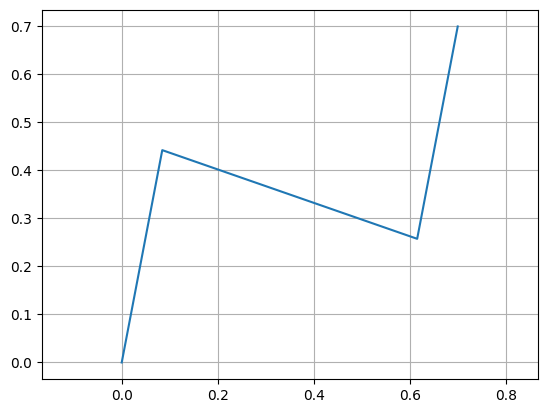

In [891]:
plt.plot(res.x[0:num_colloc],res.x[num_colloc:(2*num_colloc)])
plt.axis('equal')
plt.grid('on')
plt.show()

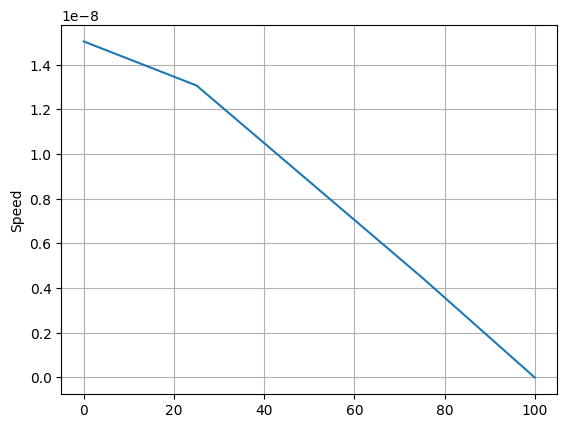

In [892]:
plt.plot(res.x[5*num_colloc]*colloc_dist,
         res.x[(3*num_colloc):(4*num_colloc)])
plt.grid('on')
plt.ylabel('Speed')
plt.show()

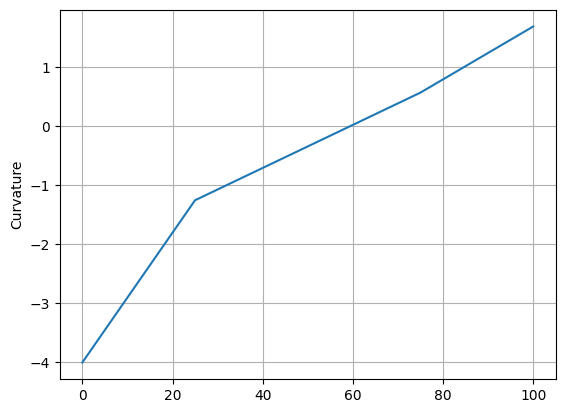

In [893]:
plt.plot(res.x[5*num_colloc]*colloc_dist,
         res.x[(4*num_colloc):(5*num_colloc)])
plt.grid('on')
plt.ylabel('Curvature')
plt.show()

In [894]:
num_vars = len(z)
num_cons = len(all_eq_constraints(z))

def lagrangian(z2):
    z = z2[0:num_vars]
    lam = z2[num_vars:]
    return cost(z) + np.dot(lam,all_eq_constraints(z))

z2 = np.concatenate((dyn_test_z,0.0*np.ones_like(all_eq_constraints(z))))

lagrangian(z2)

16.0

In [895]:
boundary_constraints(z2)

array([ 0.        ,  0.        , -0.26179939, -1.37055236, -7.02740661,
       -0.26179939])

In [896]:
dynamics_constraints(z2)

array([ 0.00000000e+00,  0.00000000e+00, -1.11022302e-16,  2.22044605e-16,
        5.55111512e-17,  5.55111512e-17, -3.88578059e-16,  6.10622664e-16,
        0.00000000e+00, -8.67361738e-18, -2.60208521e-17,  1.11022302e-16])

In [897]:
bounds2 = bounds + [(-np.inf,np.inf)]*num_cons

In [898]:
res = minimize(lagrangian,z2,method='cobyla',bounds=bounds2,options={'maxiter':1000})
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1535661.967905723
       x: [ 5.183e-01  1.000e+00 ...  6.523e+00  3.051e+01]
    nfev: 1000
   maxcv: 1.5178830414797062e-18

In [899]:
res.x

array([ 5.18261337e-01,  1.00000000e+00, -9.97243383e-01,  1.00000000e+00,
       -9.94335610e-01,  9.73920862e-01, -1.00000000e+00,  9.98428524e-01,
        6.07420105e+00,  1.09348835e+00, -6.28318531e+00,  6.22703792e+00,
        8.05275078e-01,  9.32813454e-01,  9.86270899e-01,  6.29674323e-01,
       -3.69339852e+00, -1.29620513e+00, -3.17131282e+00, -3.72354140e+00,
        1.00000000e-03, -4.39221196e+00, -1.27600790e+00, -2.92214751e+00,
       -5.43362886e+00, -5.31845040e+00, -2.80419191e+00, -4.66867860e+00,
       -5.52073487e+00, -4.44609575e+00, -4.26890126e+00, -8.85638721e+00,
       -1.38960882e+01, -4.36836770e+00, -3.69976668e+00,  2.36981873e+01,
        3.49094851e+00,  6.52348990e+00,  3.05113642e+01])

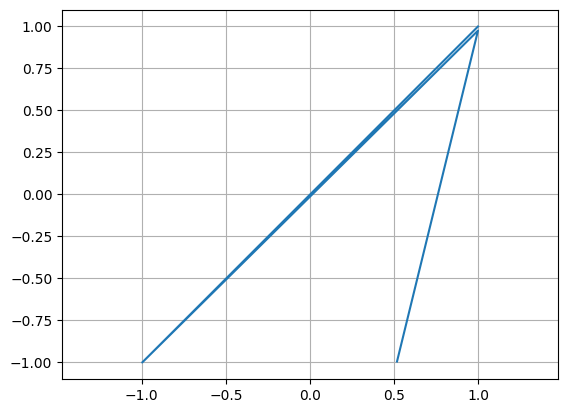

In [900]:
plt.plot(res.x[0:num_colloc],res.x[num_colloc:(2*num_colloc)])
plt.axis('equal')
plt.grid('on')
plt.show()

In [901]:
dynamics_constraints(res.x)

array([ 8.37716096e+03, -3.03183800e+03,  1.01033648e+03,  1.64597211e+04,
        1.77531332e+04, -2.80957451e+01,  5.18053121e+01,  1.79142099e+04,
       -6.73686022e+03, -2.81359300e+04,  1.85084845e+04,  8.65475018e+04])

In [902]:
boundary_constraints(res.x)

array([-0.51826134,  0.99433561, -6.07420105, -0.3       , -0.29842852,
       -6.22703792])

In [903]:
eval_dist = np.linspace(0,1,100)

In [904]:
coeffs_to_eval = np.array([eval_dist**i for i in range(len(colloc_dist))]).T
coeffs_to_eval

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.01010101e-02, 1.02030405e-04, 1.03061015e-06],
       [1.00000000e+00, 2.02020202e-02, 4.08121620e-04, 8.24488122e-06],
       [1.00000000e+00, 3.03030303e-02, 9.18273646e-04, 2.78264741e-05],
       [1.00000000e+00, 4.04040404e-02, 1.63248648e-03, 6.59590497e-05],
       [1.00000000e+00, 5.05050505e-02, 2.55076013e-03, 1.28826269e-04],
       [1.00000000e+00, 6.06060606e-02, 3.67309458e-03, 2.22611793e-04],
       [1.00000000e+00, 7.07070707e-02, 4.99948985e-03, 3.53499282e-04],
       [1.00000000e+00, 8.08080808e-02, 6.52994592e-03, 5.27672398e-04],
       [1.00000000e+00, 9.09090909e-02, 8.26446281e-03, 7.51314801e-04],
       [1.00000000e+00, 1.01010101e-01, 1.02030405e-02, 1.03061015e-03],
       [1.00000000e+00, 1.11111111e-01, 1.23456790e-02, 1.37174211e-03],
       [1.00000000e+00, 1.21212121e-01, 1.46923783e-02, 1.78089434e-03],
       [1.00000000e+00, 1.31313131e-01, 1.72431385e

In [905]:
colloc_to_eval = coeffs_to_eval@np.linalg.inv(coeffs_to_colloc)

In [906]:
colloc_test = np.array([1,2,2,3,3,2])
eval_test = colloc_to_eval@colloc_test
plt.plot(colloc_dist,colloc_test,'*r-')
plt.plot(eval_dist,eval_test,'b-')
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 4)

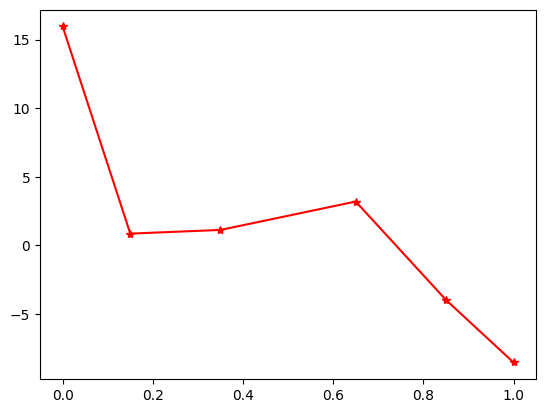

In [ ]:
colloc_deriv_test = colloc_to_colloc_deriv@colloc_test
plt.plot(colloc_dist,colloc_deriv_test,'*r-')
plt.show()